noFree_chuffed
free_chuffed
noFree_chuffed
free_chuffed


/tmp/ipykernel_1703453/2527118881.py:141: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = figure(figsize=(10, 10), dpi=80)


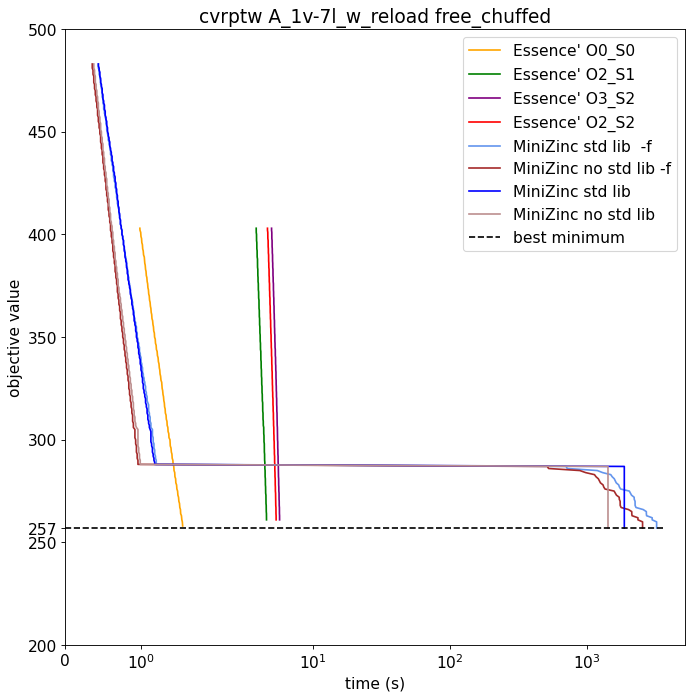

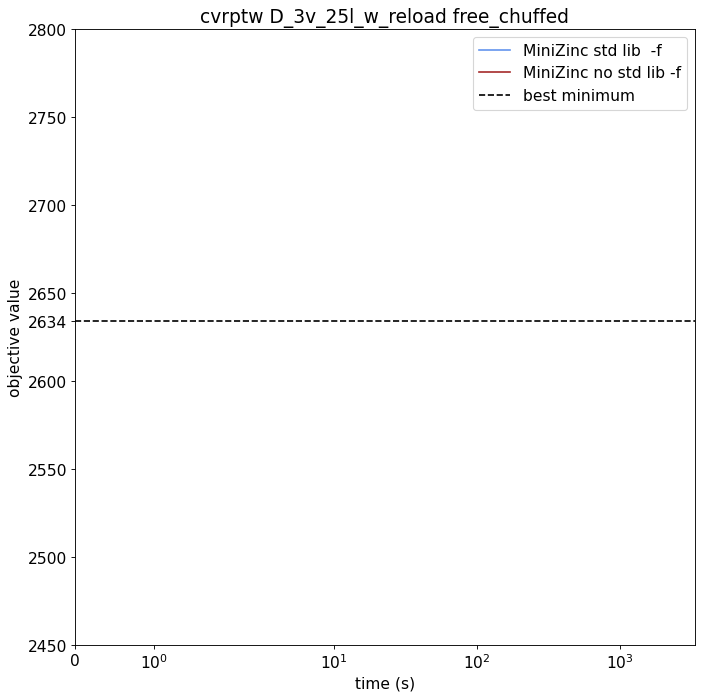

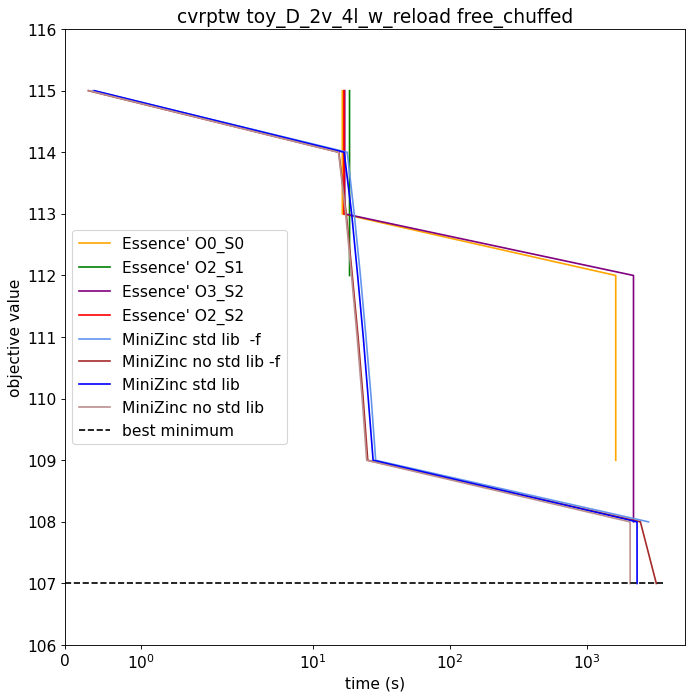

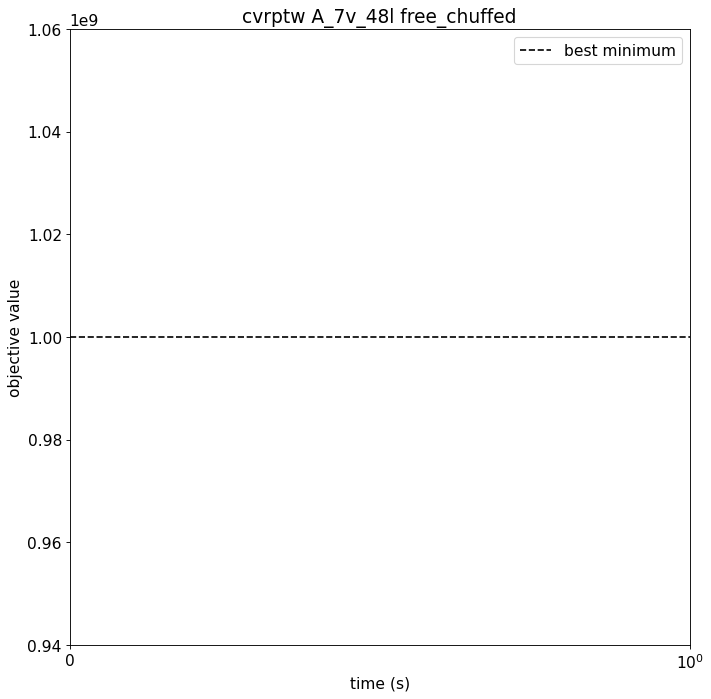

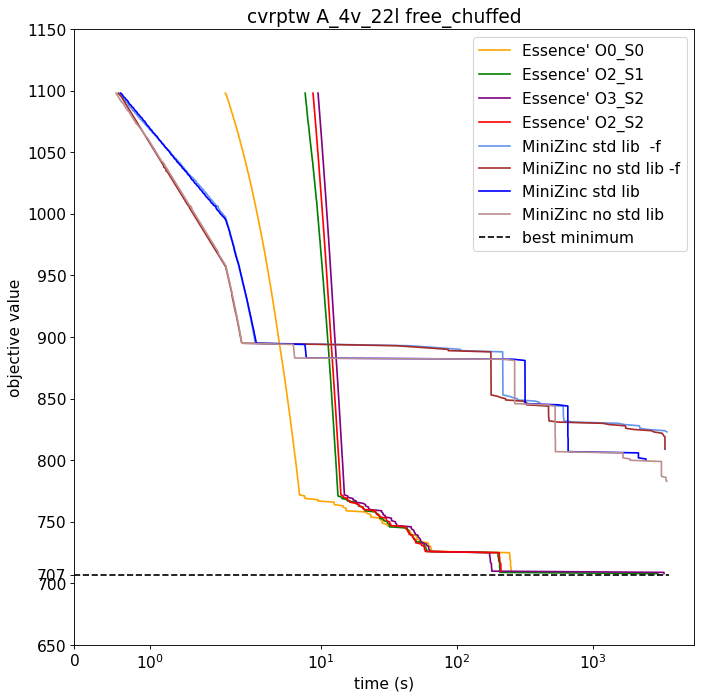

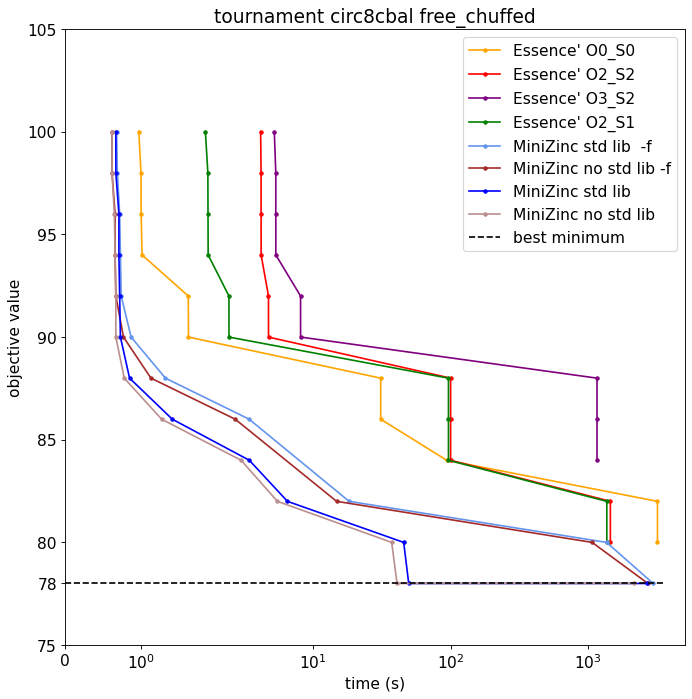

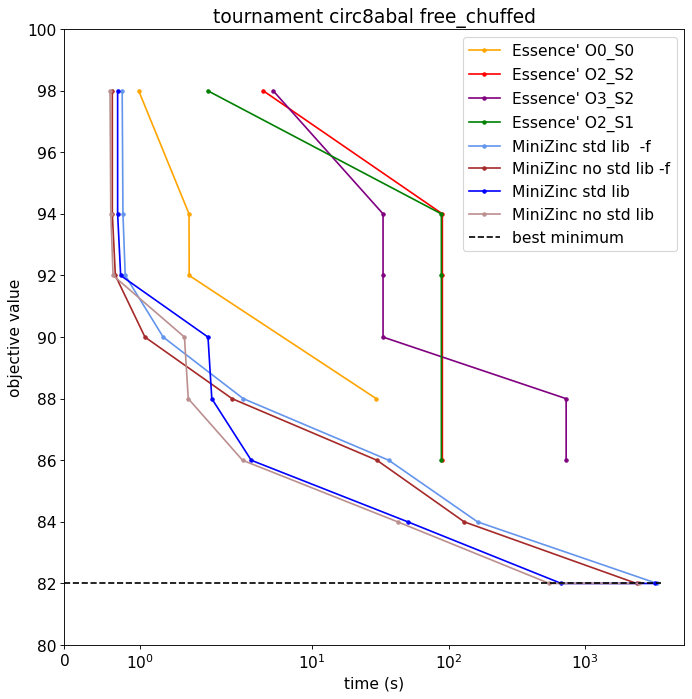

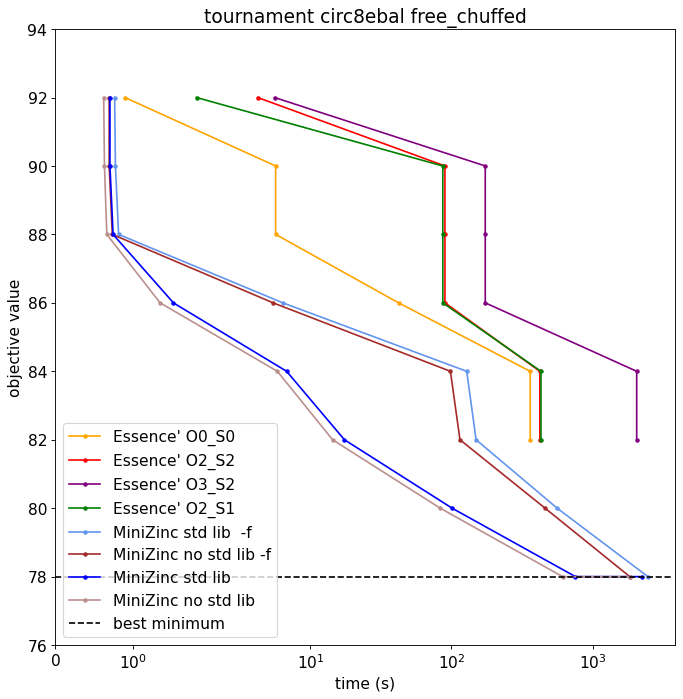

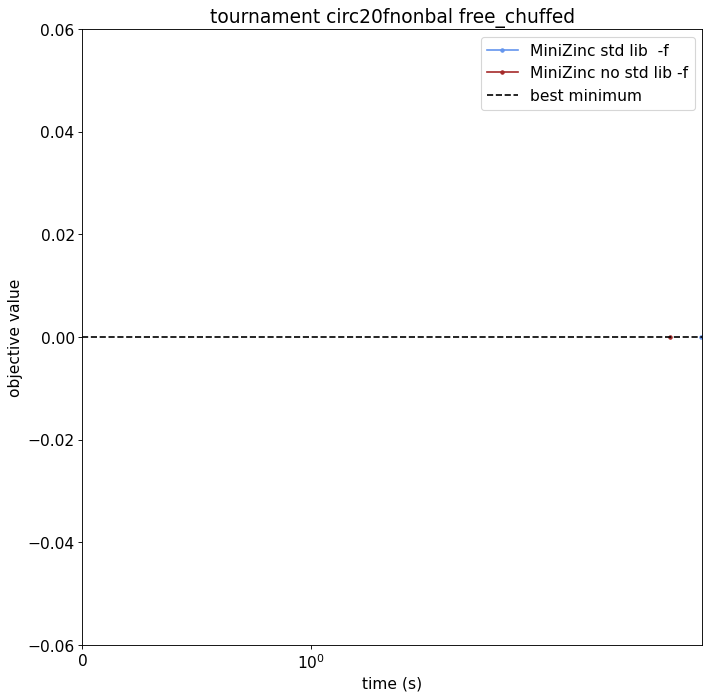

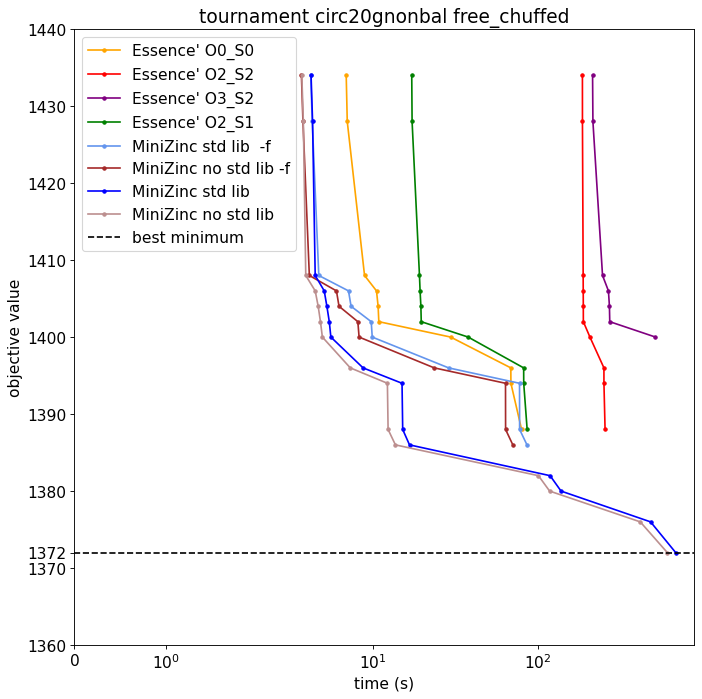

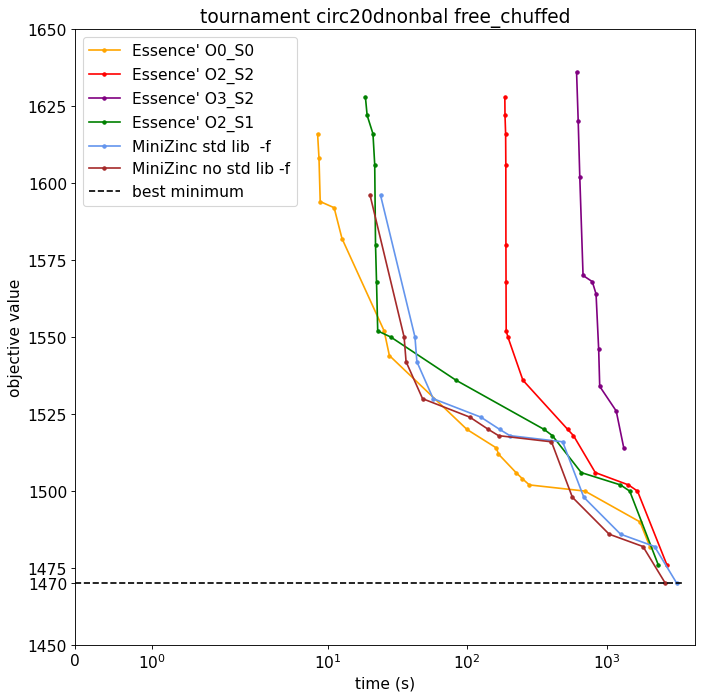

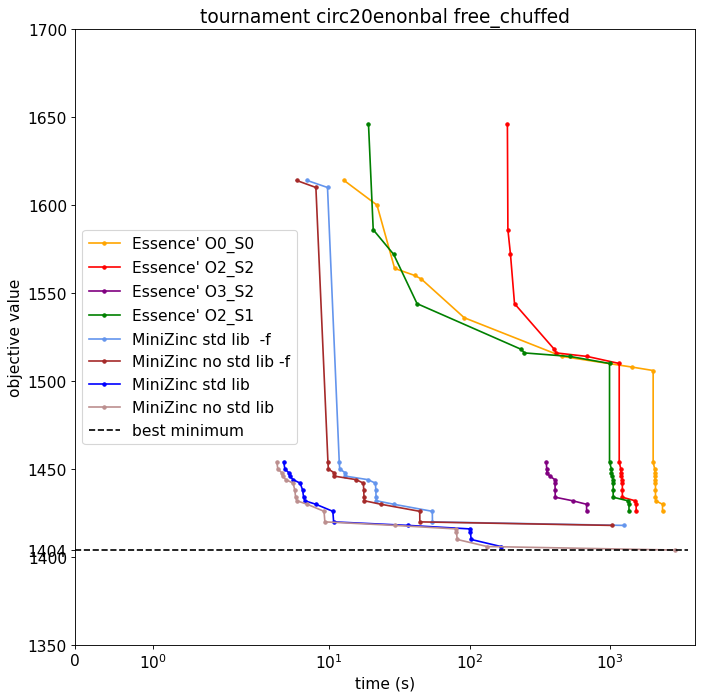

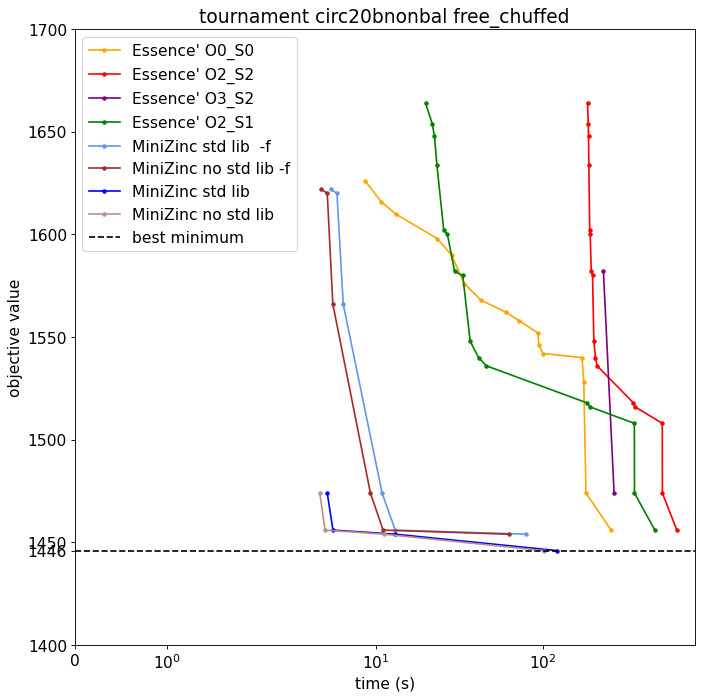

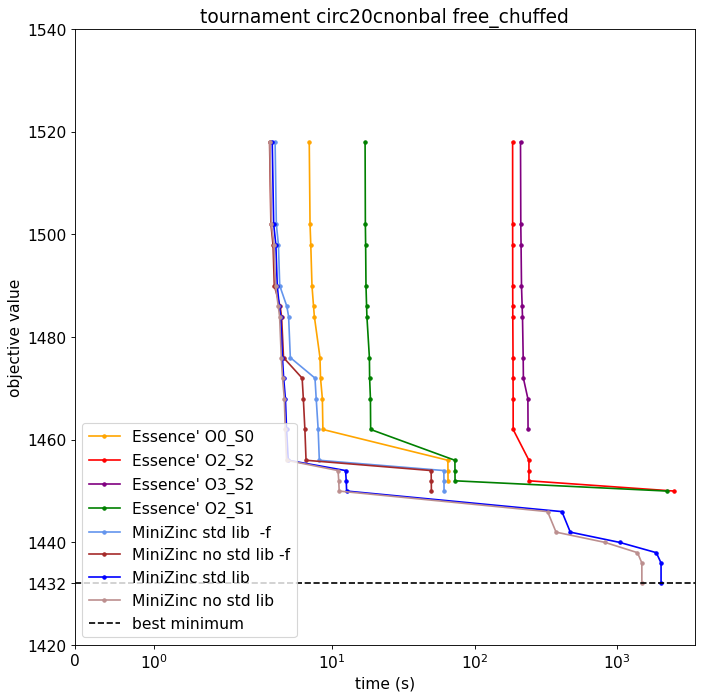

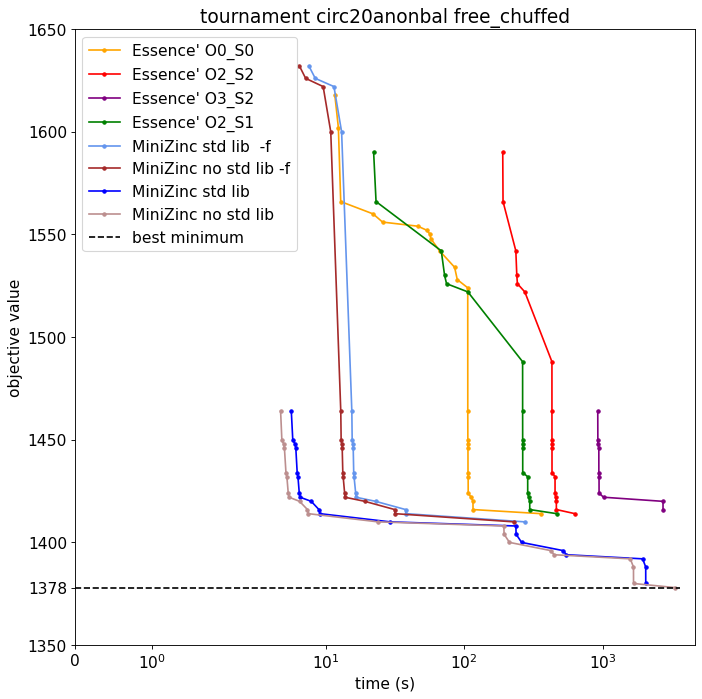

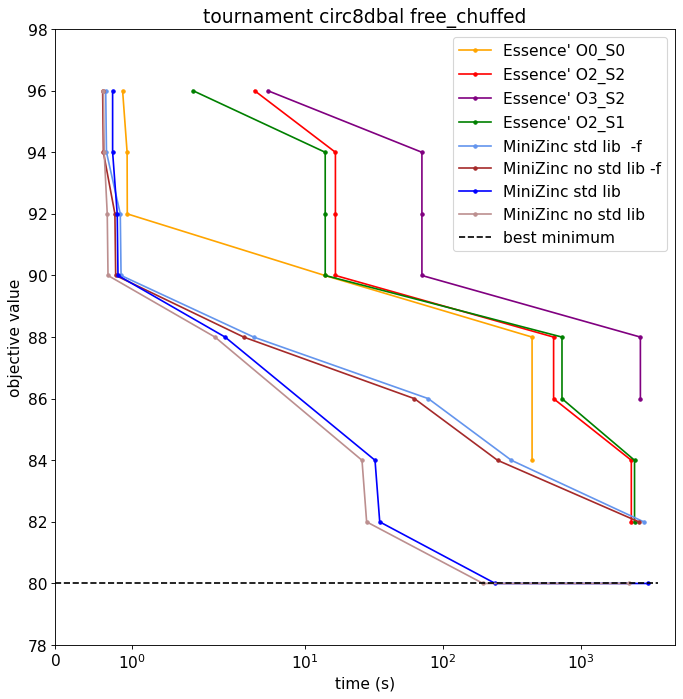

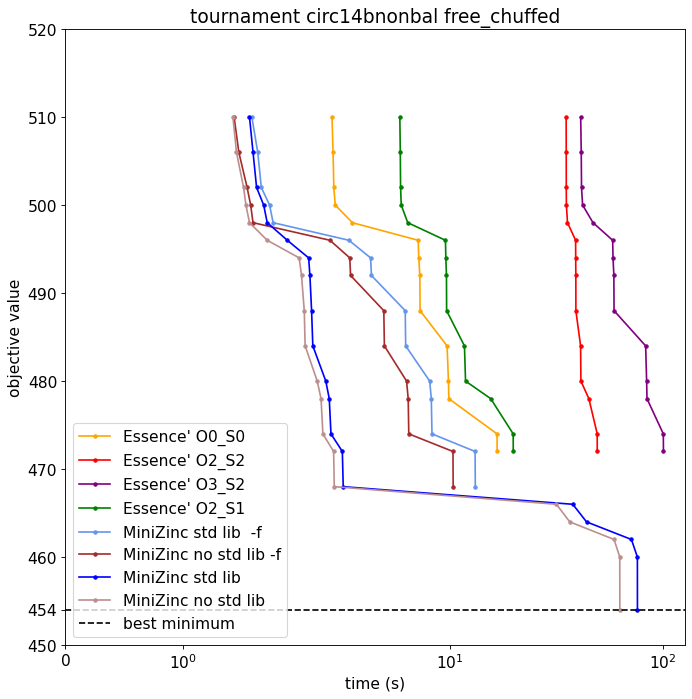

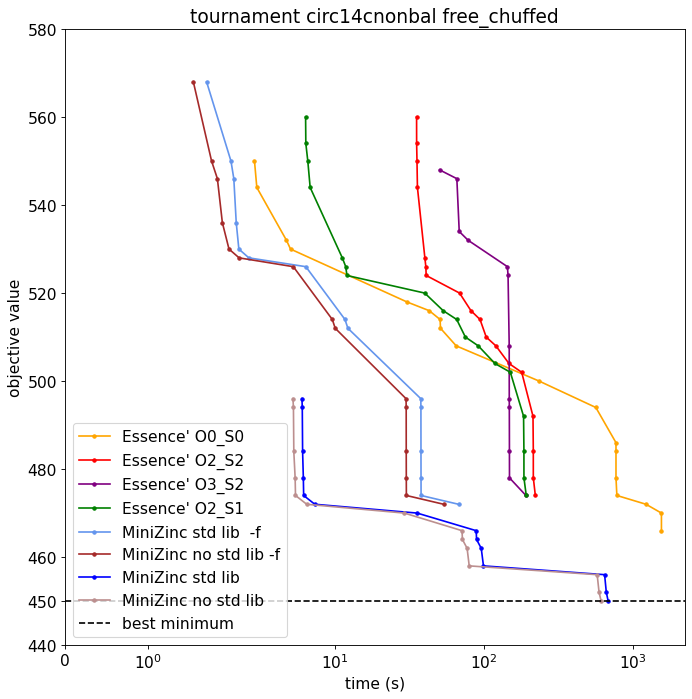

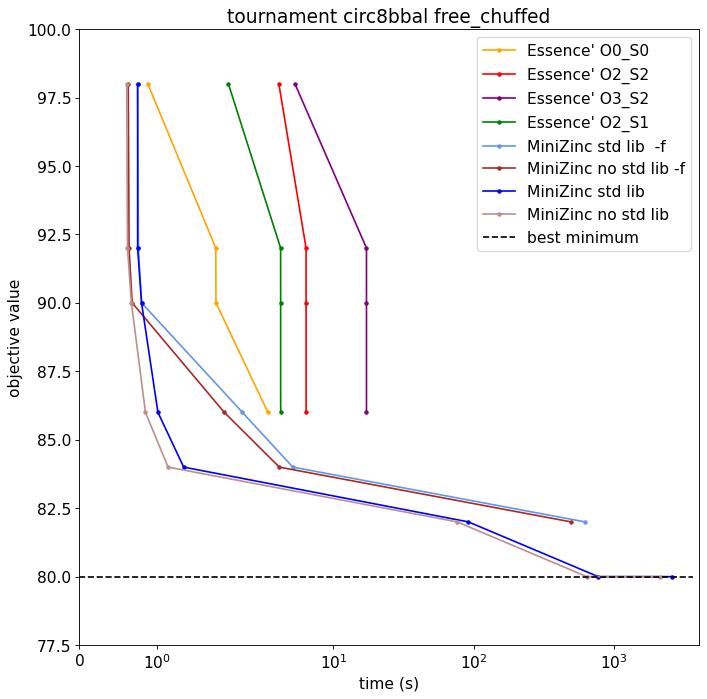

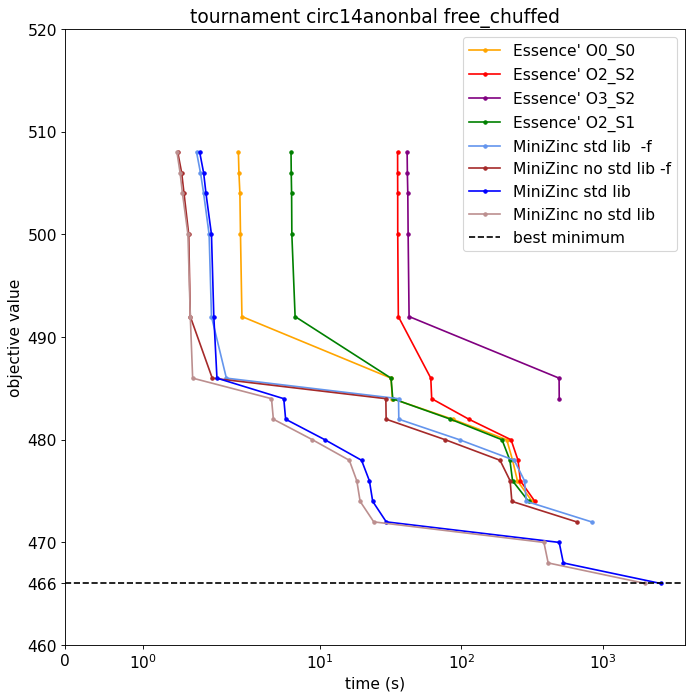

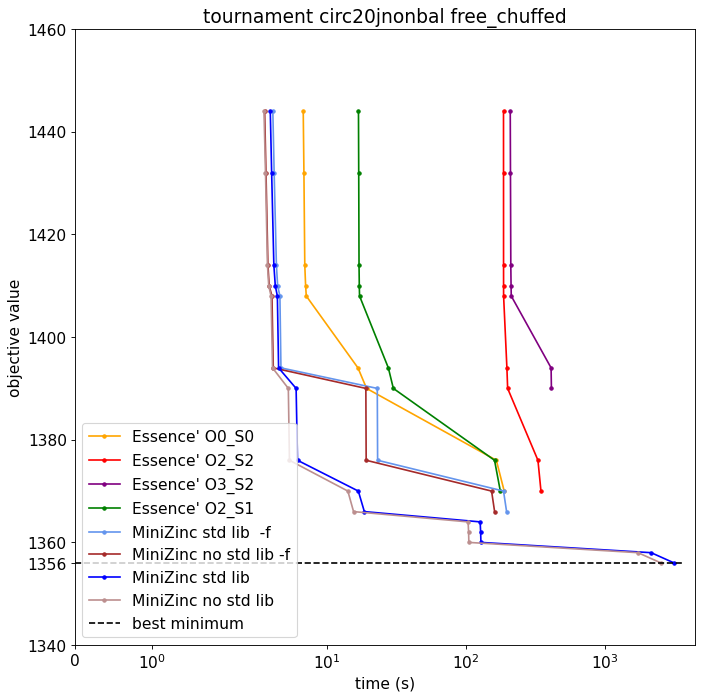

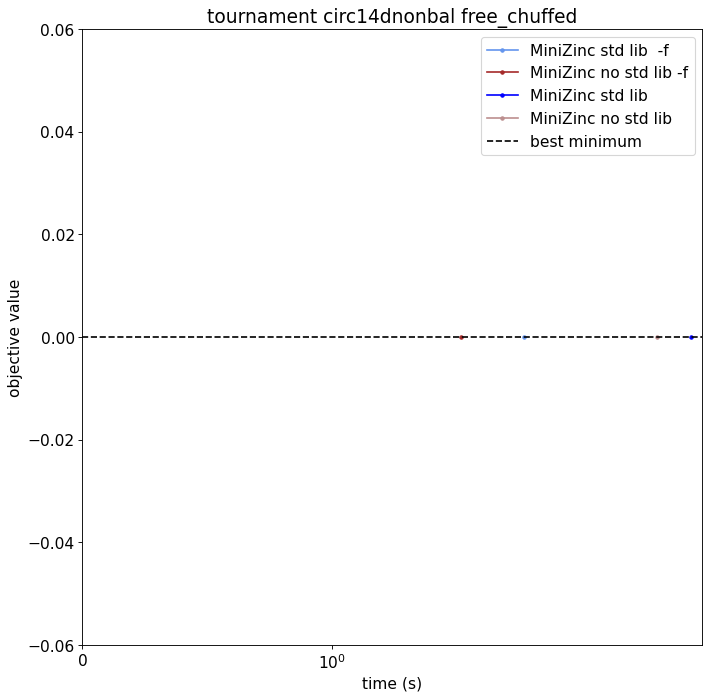

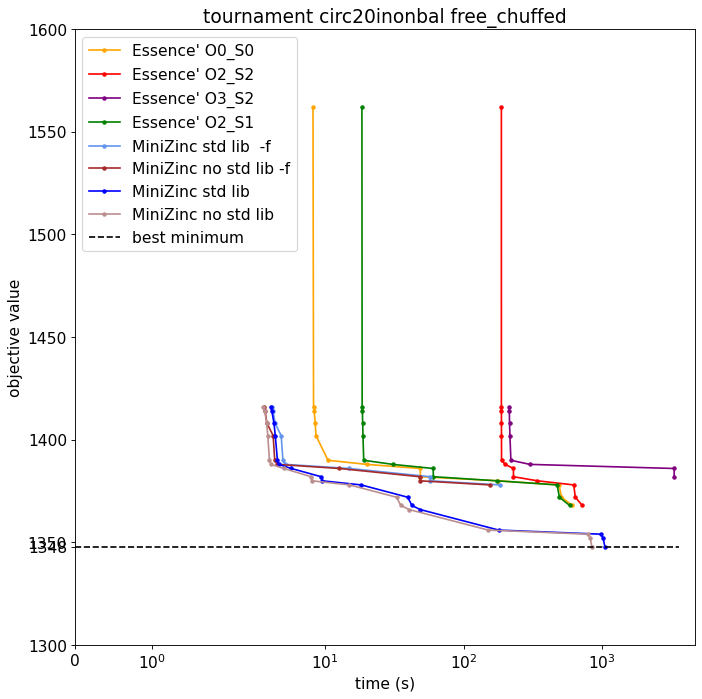

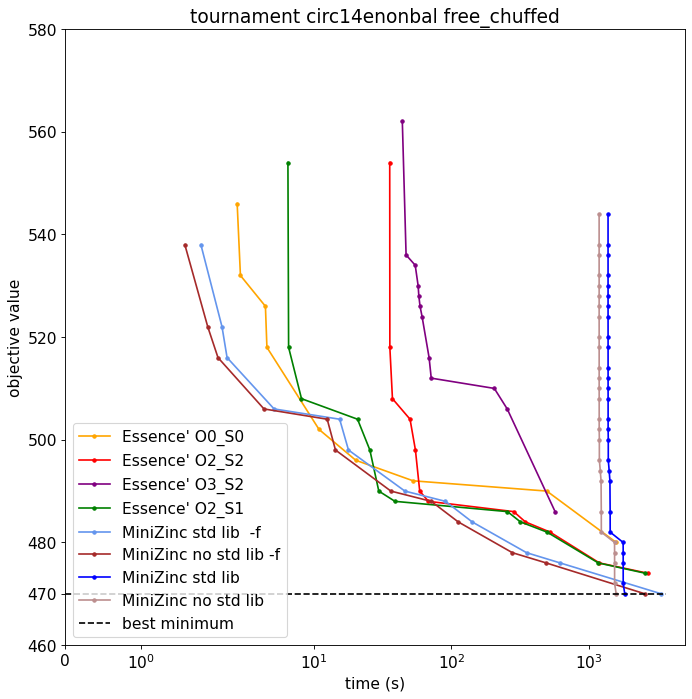

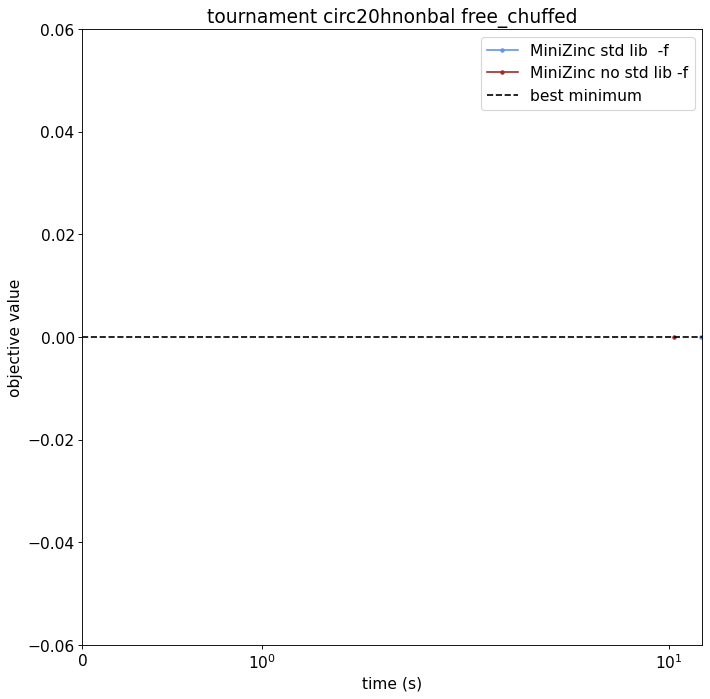

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import json


problems = ["cvrptw", "tournament"]
data_location = "../instances_and_solutions/"
objective_foler = "objective/"
timeout_secs = 3600


def get_objective(line):
    line = line.replace(";\n", "")
    splt = line.split('=')
    return int(splt[-1])


def process_minizinc_file(path):
    f = open(path)
    lines = f.readlines()
    res = []
    currObjective = 0
    for line in lines:
        if 'objective' in line:
            currObjective = get_objective(line)
        # ex "% time elapsed: 1868.99 s"
        if '% time' in line:
            line = line.replace("s\n", "")
            timing = float(line.split(':')[-1])
            if timing <= timeout_secs:
                res.append((currObjective, timing))
    return res

# gets the initialisation time for eprime problem in an ugly way
# the original data for eprime does not include the initialisation time
# because the flatzinc files from the models were reused to save recompiling them, 
# a mistake on my part given all optimisation or translation was done already, timings rectified here
def get_init_eprime(path):
    problem_location = 2
    instance_location = -1
    opt_location = 6
    path_split = path.split("/")
    instance_name = path_split[instance_location].split("_chuffed")[0]
    to_search = eprime_json[path_split[problem_location] + "_free_chuffed"][path_split[opt_location]]
    init_val = 0
    for tup in to_search:
        if tup[0] == instance_name:
            init_val = tup[-1]["initTime"]
            break
    return init_val

def process_eprime_file(path):
    init_val = get_init_eprime(path)
    f = open(path)
    lines = f.readlines()
    res = []
    currObjective = []
    prevLine = ""
    for line in lines:
        if 'Price' in line or 'objective' in line:
            currObjective.append(get_objective(line))
        if '----------' in line:
            timing = float(prevLine)+init_val
            if timing <= timeout_secs:
                res.append((sum(currObjective), timing))  
            currObjective = []
        prevLine = line
    return res

def perform_runs(instance_path, method):
    runs = []
    for run in os.scandir(instance_path):
        runs.append(method(run.path))
    timing_sum = [sum([y[-1] for y in x]) for x in runs]
    runs = [x for _, x in sorted(zip(timing_sum, runs))]
    return runs


# mzn_vals[problem][(noF)free_solver][instanceName]
mzn_vals = {}
mzn_no_std_vals = {}

def extract_mzn(pathing):
    mzn_curr = {}
    for solvers in os.scandir(pathing):
        mzn_problem = {}
        for instance in os.scandir(solvers.path):
            runs = perform_runs(instance.path, process_minizinc_file)
            mzn_problem[instance.name] = runs[1]
        mzn_curr[solvers.name] = mzn_problem
    return mzn_curr

# def extract_init_eprime(opt, instance):



def extract_eprime(pathing):
    eprime_opt = {}
    for opt in os.scandir(pathing):
        eprime_instance = {}
        for instance in os.scandir(opt.path):
            runs = perform_runs(instance.path, process_eprime_file)
            instance_name = instance.name.split(".param")[0]
            eprime_instance[instance_name] = runs[1]
        eprime_opt[opt.name] = eprime_instance
    return eprime_opt

f = open('eprime_data.json')
eprime_json = json.load(f)

# eprime_vals[problem][solver][opt][instanceName]
eprime_vals = {}
for p in problems:
    mzn_vals[p] = extract_mzn(data_location + p + "/minizinc/objective")
    mzn_no_std_vals[p] = extract_mzn(data_location + p + "/minizinc/noStdLibObjective")
    eprime_curr = {}
    for solvers in os.scandir(data_location + p + "/eprime/"):
        if solvers.name == "param" or 'gecode' in solvers.name:
            continue
        print(solvers.name)
        eprime_curr[solvers.name] = extract_eprime(solvers.path + "/objective")
        # if "noFree_chuffed" in solvers.name:
        #     eprime_curr["free_chuffed"] = eprime_curr["noFree_chuffed"]
    eprime_vals[p] = eprime_curr


coloring = {}
coloring["O0_S0"] = "orange"
coloring["O2_S1"] = "green"
coloring["O2_S2"] = "red"
coloring["O3_S2"] = "purple" 
coloring["free_chuffed"] = "cornflowerblue"
coloring["noFree_chuffed"] = "blue"
coloring["free_chuffed noStdLib"] = "brown"
coloring["noFree_chuffed noStdLib"] = "rosybrown"



def setup_figure(problem, instance_name, solver):
    fig = figure(figsize=(10, 10), dpi=80)
    plt.rcParams['font.size'] = 14
    plt.title(problem + " " + instance_name.split(".")[0] + " " + solver)
    plt.xlabel("time (s)")
    plt.ylabel("objective value")
    plt.xscale("symlog")
    
    # plt.yscale("symlog")

curr_min_obj = 1000000000

def plot_eprime(p, solver, instance_name, marker):
    global curr_min_obj
    for opt in eprime_vals[p][solver]:
        eprime_data = eprime_vals[p][solver][opt][instance_name]
        if len(eprime_data) == 0:
            continue
        y_eprime =  [y[0] for y in eprime_data]
        curr_min_obj = min(curr_min_obj, *y_eprime)
        plt.plot([x[-1] for x in eprime_data], y_eprime, label='Essence\' ' + opt, marker=marker, color=coloring[opt])

def plot_mzn(p, solver, instance_name, marker):
    global curr_min_obj
    curr_mzn = mzn_vals[p][solver][instance_name]
    no_std_lib = mzn_no_std_vals[p][solver][instance_name]
    # if len(curr_mzn) == 0 and len(no_std_lib) == 0:
    #     continue
    y_curr_mzn = [y[0] for y in curr_mzn]
    y_no_std_lib = [y[0] for y in no_std_lib]
    if len(y_curr_mzn) == 0 and len(y_no_std_lib) == 0:
        return
    curr_min_obj = min(curr_min_obj, *y_curr_mzn, *y_no_std_lib)
    free_flag = '' if 'noFree' in solver else ' -f'
    plt.plot([x[-1] for x in curr_mzn], y_curr_mzn, label='MiniZinc std lib ' +  free_flag, marker=marker, color=coloring[solver])
    plt.plot([x[-1] for x in no_std_lib],y_no_std_lib, label='MiniZinc no std lib' + free_flag , marker=marker, color=coloring[solver + " noStdLib"])



for p in problems:
    for solver in eprime_vals[p].keys():
        if 'noFree' in solver:
            continue  
        for instance_name in mzn_vals[p][solver].keys(): 
            curr_min_obj = 1000000000
            marker = '.' if 'circ' in instance_name else None
            setup_figure(p, instance_name, solver)
            plot_eprime(p, solver, instance_name, marker)
            # plot_mzn(p, solver, instance_name, marker)
            # plot_mzn(p, "noFree_chuffed", instance_name, marker)
            plot_mzn(p, "free_chuffed", instance_name, marker)
            plot_mzn(p, "noFree_chuffed", instance_name, marker)
            plt.xlim(left=0)
            plt.plot([0, timeout_secs], [curr_min_obj, curr_min_obj], linestyle="--", color="black", label="best minimum")
            yticks = list(plt.yticks()[0])
            if curr_min_obj not in yticks:
                yticks.append(curr_min_obj)
            plt.yticks(yticks)
            plt.legend()
